**IMAGE RECONSTRUCTION USING AUTOENCODER**

***Making necessary imports***

In [ ]:
import os
import random
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import tensorflow as tf
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from keras.layers import Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.utils import plot_model
from skimage.io import imread
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import shutil
from os import listdir
from os.path import isfile, join

***Mounting drive***

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Link to the dataset: <br>
https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset

***Unzipping Dataset***

In [ ]:
!unzip -o -q "/drive/MyDrive/Image Reconstruction/dataset.zip" -d "/content/data/"

***Copying dataset in same directory***

In [ ]:
from pathlib import Path
import shutil
import os
src = '/content/data/dataset/female' # source directory
trg = '/content/data/dataset/male'   # Destination directory
files=os.listdir(src)
for fname in files:
    shutil.copy2(os.path.join(src,fname), trg)

***Shuffling the dataset in ramdomized order***

In [ ]:
mypath = '/content/data/dataset/male'
fl = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
np.random.shuffle(fl)

***Storing the path of each image***

In [ ]:
filenames = []
for i in fl:
  filenames.append("/content/data/dataset/male/" + i)
filenames = np.array(filenames)

***Function to draw black box on image which will act as a masked image***

In [ ]:
def draw_square_on_image(image):
    cv2.rectangle(image, (0,128), (128,64), (0,0,0), -1)
    return np.array(image)

***Creating Image Data Generator***

In [ ]:
def custom_image_generator(files, data_instances, batch_size = 64):
    iter= 0
    while True:
        for ind in range(0, data_instances, batch_size):
          input_batch = files[ind:ind + batch_size]   # Creating batch
          batch_input,proc_batch = [],[]
          for path in input_batch:
            img = imread(path)                        # Reading image
            img = cv2.resize(img,(128,128))           # Reshaping
            img = img/255.0                           # Normalizing
            img_c = draw_square_on_image(img.copy())  # creating the mask image
            batch_input.append(img_c)
            proc_batch.append(img)
          corrupted_images_batch = np.array(batch_input)
          original_images_batch = np.array(proc_batch)

        # move to the next batch
          yield (corrupted_images_batch, original_images_batch)
          if iter >= batch_size:
            iter = 0
          iter = iter + 1
        

***Image Grid Display***

In [ ]:
def display_image_grid(images, num_rows, num_cols, title_text):
    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)
    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis("off")
    plt.suptitle(title_text, fontsize=20)
    plt.show()

***Testing Generator and display***

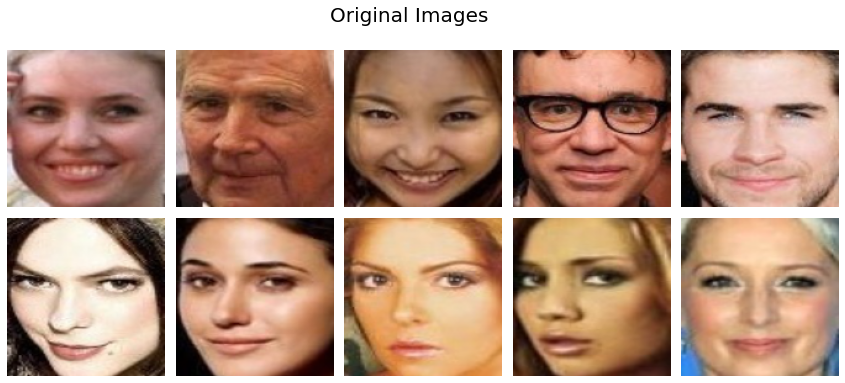

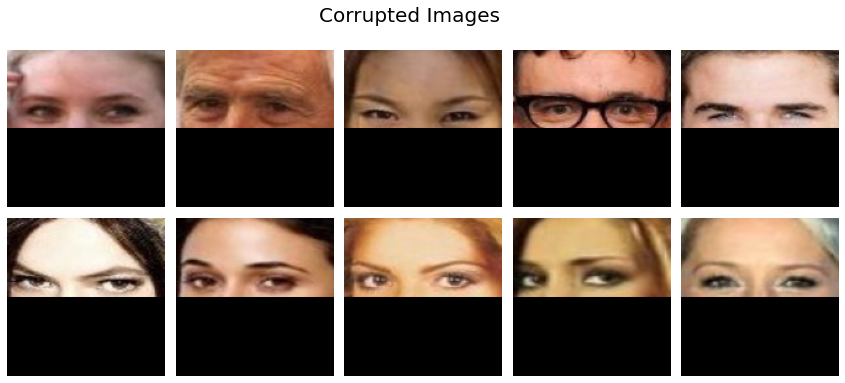

In [ ]:
# get first batch of images
test_generator = custom_image_generator(filenames, 7000)
(corrupted_images_batch, orig_images_batch) = next(test_generator)

# only displaying 10 images from both batch
display_image_grid(orig_images_batch[:10], 2, 5, "Original Images")
display_image_grid(corrupted_images_batch[:10], 2, 5, "Corrupted Images")

***Encoder***

In [ ]:
INPUT_DIM = (128,128,3) # Image dimension
Latent_Dim = 1000   #Latent Space

ae_encoder_output = Latent_Dim
ae_encoder_input = INPUT_DIM

inputs = Input(shape=INPUT_DIM)
x = inputs
filters = [32,32,32]
for f in filters:
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=-1)(x)
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(Latent_Dim)(x)

ae_encoder = Model(inputs, latent)
ae_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                             

***Decoder***

In [ ]:
latentInputs = Input(shape=(Latent_Dim,))
x = Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

for f in filters[::-1]:
    x = Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=-1)(x)

x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

ae_decoder = Model(latentInputs,outputs)
ae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_1 (Dense)             (None, 8192)              8200192   
                                                                 
 reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 32)       9248      
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                           

***Attaching encoder and decoder***

In [ ]:
autoencoder_model = Model(inputs, ae_decoder(ae_encoder(inputs)),name="autoencoder")
autoencoder_model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 model (Functional)          (None, 1000)              8212776   
                                                                 
 model_1 (Functional)        (None, 128, 128, 3)       8229187   
                                                                 
Total params: 16,441,963
Trainable params: 16,441,579
Non-trainable params: 384
_________________________________________________________________


***Compiling the autoencoder***

In [ ]:
LEARNING_RATE = 0.0005    # learning rate
N_EPOCHS = 10             # epochs
BATCH_SIZE = 64           # batch of images returned by image data generator

train = filenames[:-5000]
custom_generator = custom_image_generator(train, 42000, BATCH_SIZE)

opt = Adam(lr=LEARNING_RATE)
autoencoder_model.compile(loss="MSE", optimizer=opt)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


***Training***

In [ ]:
H = autoencoder_model.fit(custom_generator, steps_per_epoch = len(train)//BATCH_SIZE,epochs=N_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
656/656 [==============================] - 65s 94ms/step - loss: 0.0154
Epoch 2/10
656/656 [==============================] - 59s 90ms/step - loss: 0.0098
Epoch 3/10
656/656 [==============================] - 65s 100ms/step - loss: 0.0090
Epoch 4/10
656/656 [==============================] - 61s 93ms/step - loss: 0.0086
Epoch 5/10
656/656 [==============================] - 60s 91ms/step - loss: 0.0082
Epoch 6/10
656/656 [==============================] - 59s 91ms/step - loss: 0.0080
Epoch 7/10
656/656 [==============================] - 59s 90ms/step - loss: 0.0077
Epoch 8/10
656/656 [==============================] - 61s 93ms/step - loss: 0.0075
Epoch 9/10
656/656 [==============================] - 64s 97ms/step - loss: 0.0073
Epoch 10/10
656/656 [==============================] - 60s 91ms/step - loss: 0.0071


***Reconstructing the image***

1/1 [==============================] - 0s 18ms/step


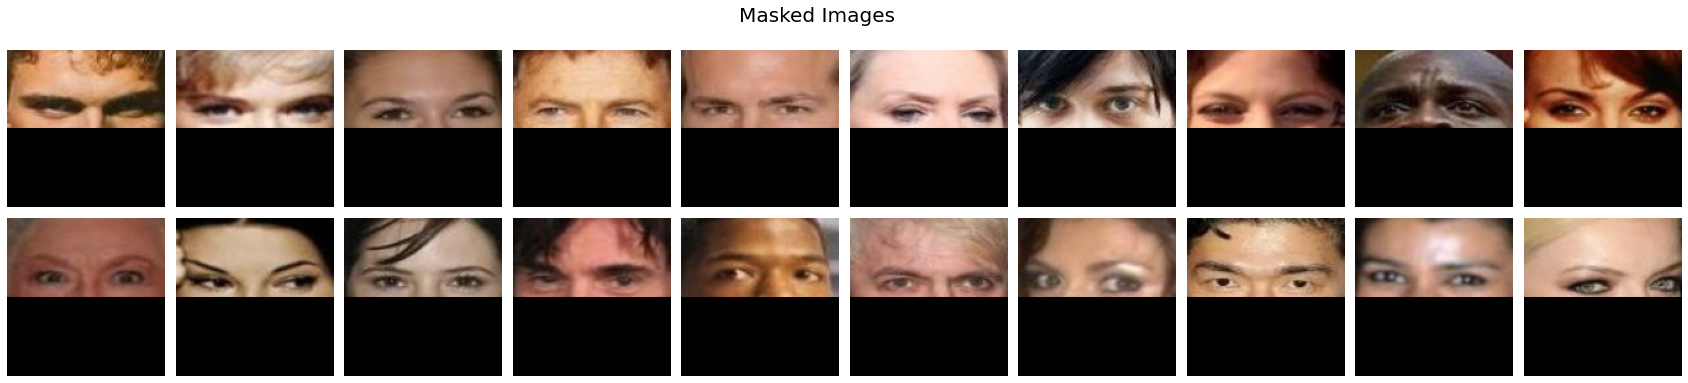

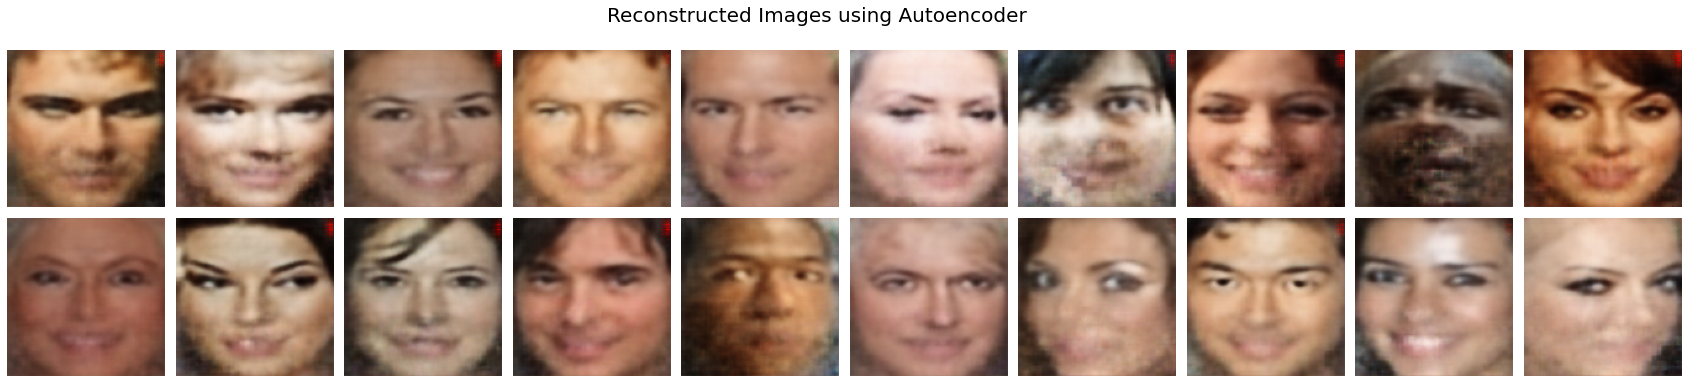

In [ ]:
test = filenames[-5000:]
test_gen = custom_image_generator(test, 5000)

test_batch = next(test_gen)[0]
test_images = test_batch[:20]

reconst_images = autoencoder_model.predict(test_images)

display_image_grid(test_images, 2, 10, "Masked Images")
display_image_grid(reconst_images, 2, 10, "Reconstructed Images using Autoencoder")